# Pytorch Paper Replicating

In this notebook, we're going to be replicating a machine learning research paper and creating a Vision Transformer(ViT) from scratch using PyTorch.

We'll then see how ViT, a state-of-the-art computer vision architecture, performs on our FoodVision Mini problem.

The goal of *paper replicating* is to replicate the advances with code so you can use the techniques for your own problem.

* Machine learning paper replicating involves turning a machine learning paper comprised of images/diagrams, maths and text into usable code and in our case, usable PyTorch code.

#### What is a machine learning research paper?

* Abstract : An overview/summary of the paper's main findings/contributions.
* Introduction : What's the paper's main problem and details of previous methods used to try and solve it.
* Method : How did the researchers go about conducting their research? For example, what model(s), data sources, training setups were used?
* Results : What are the outcomes of the paper? If a new type of model or training setup was used, how did it perform compared to previous methods? 
* Conclusion : What are the key takeaways from the paper? What are the future steps for research in the area?
* References : Other papers or resources mentioned in the paper.
* Appendix : Extra information such as mathematical proofs or theoretical concepts.

#### We are going to replicate the `Vanilla Vision Transformer`

# 0. Getting setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cpu
torchvision version: 0.20.1+cpu


In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
# Regular imports
import matplotlib.pyplot as plt
import torch
import torchvision 

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print(f"{bcolors.WARNING} [INFO] torchinfo not found, installing torchinfo...{bcolors.ENDC}")
    %pip install -q torchinfo
    from torchinfo import summary
    
# Try to import the going_modular directory, download it from Github if it doesn't work

try:
    from going_modular import data_setup, engine
    from utils import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular directory scripts
    print(f"{bcolors.WARNING} [INFO] going_modular package not found, downloading...{bcolors.ENDC}")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning.git
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:
# device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{bcolors.OKCYAN} [INFO] Using {device} device{bcolors.ENDC}")

 [INFO] Using cpu device


# 1. Get Data

In [5]:
# Download pizza, steak and sushi images from github
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)

[INFO] data\pizza_steak_sushi directory exists, skipping download.


In [6]:
# Since i have already downloaded the data, i will just set the path
from pathlib import Path
image_path = Path("data/pizza_steak_sushi/")

# Setup directory paths to train and test data
train_dir = image_path / "train"
test_dir = image_path / "test"

image_path, train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi'),
 WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

# 2. Create Datasets and DataLoaders

## 2.1 Prepare transforms for images

In [7]:
# From ViT paper, the authors used an image size of 224x224 and batch size of 4096

# Create a Image size (from Table 3 in the ViT Paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"{bcolors.OKCYAN} [INFO] Using manual transforms: {manual_transforms}{bcolors.ENDC}")

 [INFO] Using manual transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 2.2 Turn images into `DataLoader`'s

In [8]:
# Even though the authors used a batch size of 4096, we will use a batch size of 34 dues to memory constraints
# Set the batch size
BATCH_SIZE = 32

# Create the data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
    test_transform=manual_transforms,
    train_transform=manual_transforms
)

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x211157cd4c0>,
 ['pizza', 'steak', 'sushi'])

## Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

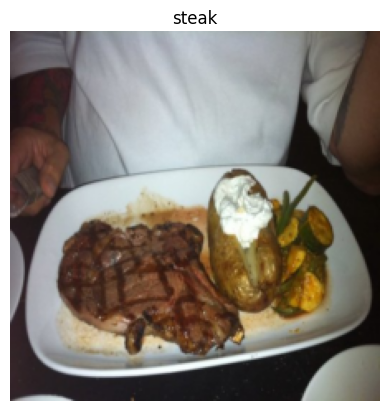

In [10]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib
plt.title(class_names[label])
plt.axis(False);

# 3. Replicating the ViT paper: an overview

## 3.1 Inputs and outputs, layers and blocks

ViT is a deep learning neural network architecture.

And any neural network architecture is generally comprised of layers.

And a collection of layers is often referred to as a block.

And stacking many blocks together is what gives us the whole architecture.

A layer takes an input (say an image tensor), performs some kind of function on it (for example what's in the layer's forward() method) and then returns an output.

So if a single layer takes an input and gives an output, then a collection of layers or a block also takes an input and gives an output.

Let's make this concrete:

* Layer - takes an input, performs a function on it, returns an output.
* Block - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* Architecture (or model) - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the ViT paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

## 3.2 Getting specific: What ViT made of?

Remember, a research paper is often months of work compressed into a few pages so it's understandable for it to take of practice to replicate.

However, the main three resources we'll be looking at for the architecture design are:

1. Figure 1 - This gives an overview of the model in a graphical sense, you could almost recreate the architecture with this figure alone.
2. Four equations in section 3.1 - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. Table 1 - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.


### 3.2.1 Exploring Figure 1.


1. Layers - takes an input, performs an operation or function on the input, produces an output.
2. Blocks - a collection of layers, which in turn also takes an input and produces an output.

![image](di83dth1.bmp)

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.*

The ViT architecture is comprised of several stages:

1. Patch + Position Embedding (inputs) - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
2 Linear projection of flattened patches (Embedded Patches) - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
3. Norm - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().
4. Multi-Head Attention - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().
5. MLP (or Multilayer perceptron) - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendix B.1).
6. Transformer Encoder - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
7. MLP Head - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.


### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper
![image](t5l9ztdb.bmp)

# 4. Equation 1: Split data into patches and creating the class, position and patch embedding.

Let's start by creating the class, position and patch embeddinggs for the ViT architecture.

*<b>embedding</b>* is a learnable representation of some form and is often a vector.

## 4.1 Calculating patch emedding input and output shapes by hand

In [11]:
# Create sample values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate N (number of patches)
N = int((height * width) / patch_size**2)
print(f"{bcolors.OKCYAN} [INFO] Number of patches: {N}{bcolors.ENDC}")

 [INFO] Number of patches: 196


In [12]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape of the embedding layer
embedding_layer_output_shape = (N, patch_size**2 * color_channels)

print(f"{bcolors.OKGREEN} [INFO] Input Shape (single 2D image): {embedding_layer_input_shape}")
print(f"{bcolors.OKCYAN} [INFO] Embedding layer will turn {embedding_layer_input_shape} image shape into {embedding_layer_output_shape} shape{bcolors.ENDC}")

 [INFO] Input Shape (single 2D image): (224, 224, 3)
 [INFO] Embedding layer will turn (224, 224, 3) image shape into (196, 768) shape


## 4.2 Turning a single image into patches

Let's create the patch embedding layer

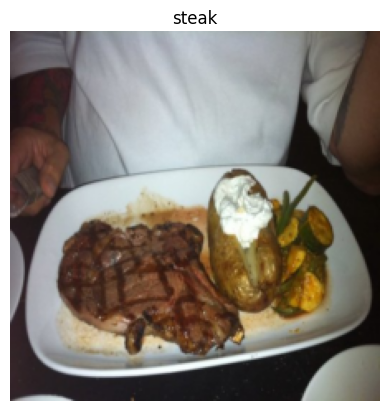

In [13]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust image for matplotlib
plt.title(class_names[label])
plt.axis(False);

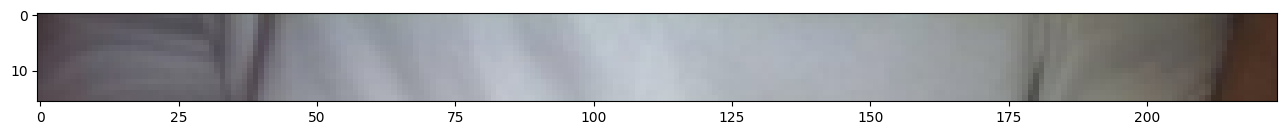

In [14]:
# Change image shape to be compatible with matplot lib (3, 224, 224) -> (224, 224, 3)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:]);

 Number of patches per row: 14.0
 16 pixels x 16 pixels each.
0
16
32
48
64
80
96
112
128
144
160
176
192
208


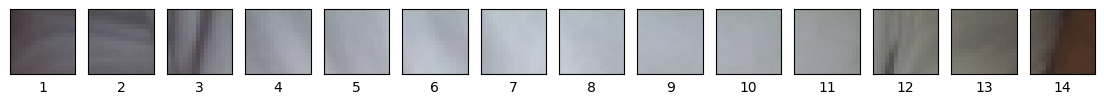

In [15]:
# Setup hyperparameters
image_size = 224
patch_size = 16
num_patches = image_size/patch_size
assert image_size % patch_size == 0, "image size must be divisible by patch size"
print(f"{bcolors.OKCYAN} Number of patches per row: {num_patches}\n {patch_size} pixels x {patch_size} pixels each.{bcolors.ENDC}")


# Create a series of subplots
fig, ax = plt.subplots(
    nrows=1,
    ncols=int(num_patches),
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, image_size, patch_size)):
    # Select the patch
    print(patch)
    ax[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    ax[i].set_xlabel(i+1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    

[INFO] Number of patches per row: 14      
patch_size 16 pixels x 16 pixels each.      
Number of patches per column: 14        
Total number of patches: 196      


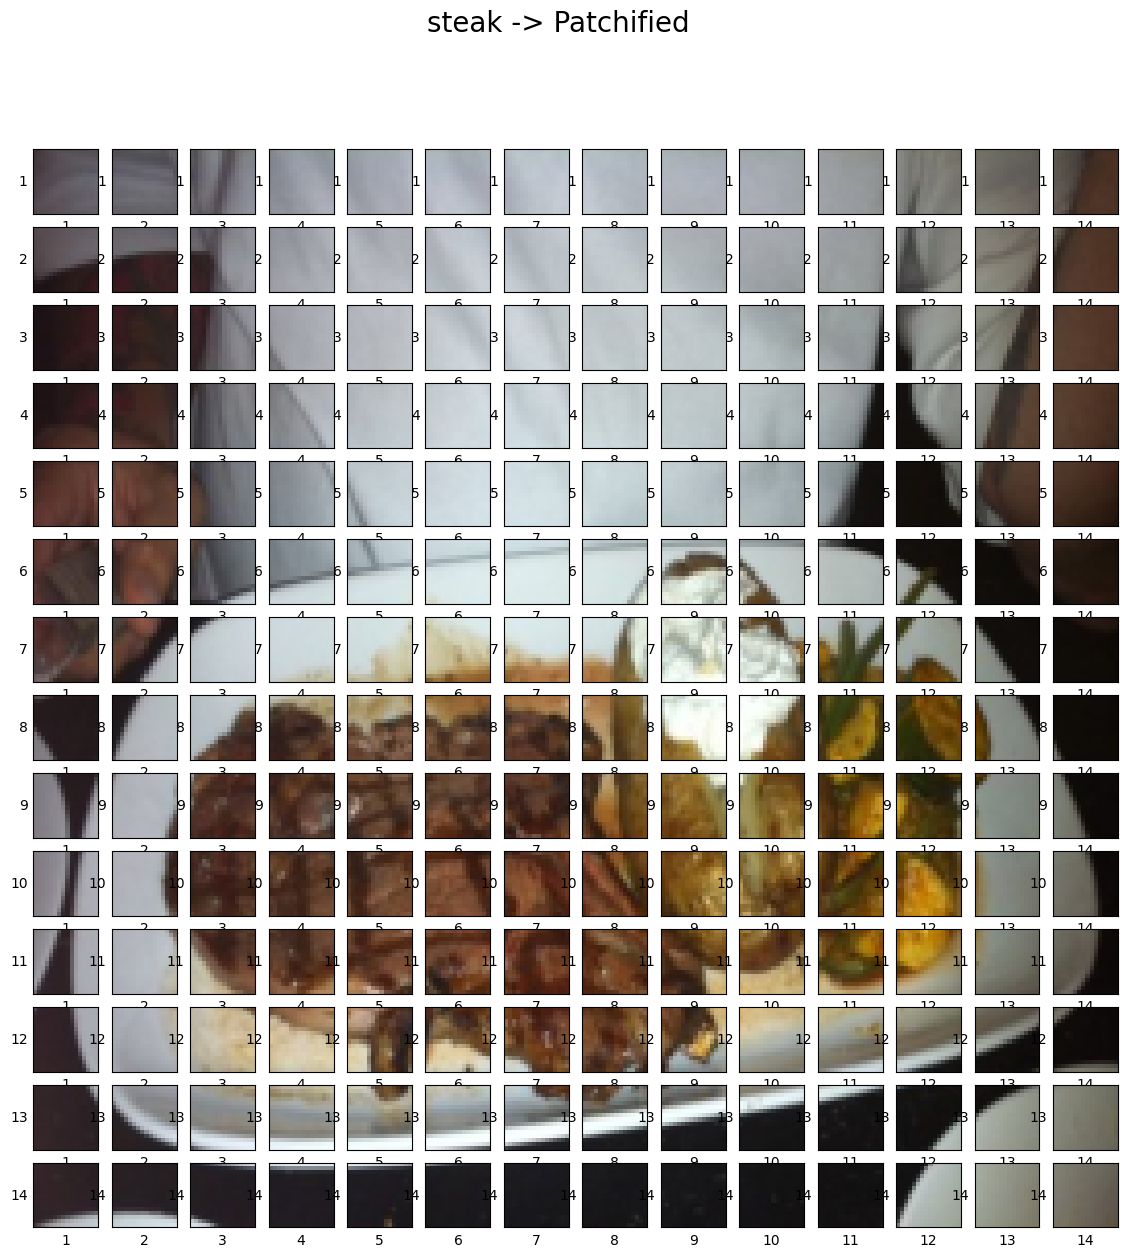

In [16]:
# Let's iterate through whole image
# Setup hyperparameters
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"{bcolors.OKGREEN}[INFO] Number of patches per row: {num_patches}\
      \npatch_size {patch_size} pixels x {patch_size} pixels each.\
      \nNumber of patches per column: {num_patches}\
        \nTotal number of patches: {num_patches**2}\
      {bcolors.ENDC}")

# Create a series of subplots
fig, ax = plt.subplots(
    nrows=int(num_patches),
    ncols=int(num_patches),
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

# Loop througgh height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color_channels))
        ax[i, j].imshow(image_permuted[patch_height: patch_height+patch_size, #iterate through height
                                       patch_width: patch_width+patch_size, #iterate through width
                                       :])
        # Setup up label information, remove the ticks for better visualization 
        ax[i, j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center")
        ax[i, j].set_xlabel(j+1)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=20) 
plt.show()       

## 4.3 Creating image patches with `torch.nn.Conv2d()`
*By setting the kernel_size and stride parameters of a torch.nn.Conv2d() layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch*

In [17]:
from torch import nn

# set patch size
patch_size = 16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(
    in_channels=3, # input image has 3 color channels
    out_channels=patch_size*patch_size*3, # each patch will be 16x16 pixels in size
    kernel_size=patch_size, # kernel size will be 16x16 pixels
    stride=patch_size, # stride will be 16 pixels
    padding=0
)

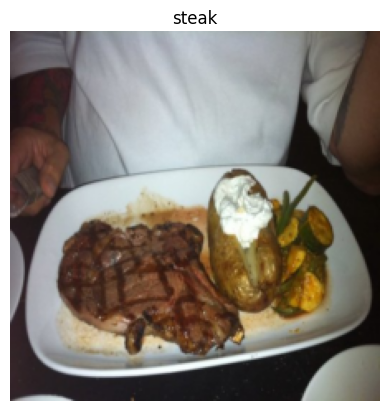

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust image for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [19]:
# Pass the imaeg through the conv2d layer
img_out_of_conv = conv2d(image.unsqueeze(0))
print(img_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Let's visualize five random feature maps and see what they look like.

 [INFO] Random indexes: [26, 456, 337, 374, 253]


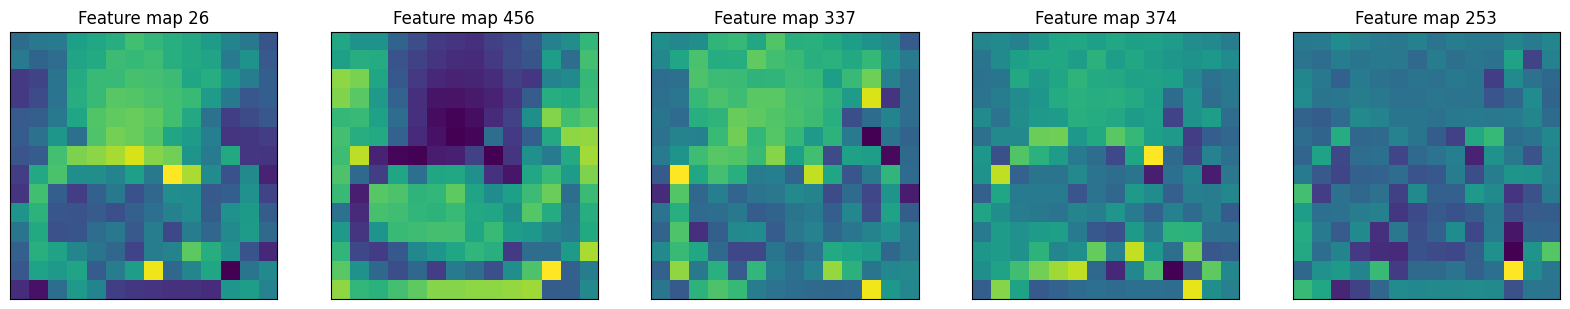

In [20]:
# Plot random 5 convolutional features maps
import random
random_indexes = random.sample(range(0,768), k=5)
print(f"{bcolors.OKCYAN} [INFO] Random indexes: {random_indexes}{bcolors.ENDC}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))

# Loop through random indexes and plot the feature maps
for i, index in enumerate(random_indexes):
    image_conv_feature_map = img_out_of_conv[:, index, :, :].squeeze()
    axs[i].imshow(image_conv_feature_map.detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f"Feature map {index}")

In [21]:
# Get a single feature map in tensor form
single_feature_map = img_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.3276,  0.3775,  0.2897,  0.5393,  0.5746,  0.6389,  0.6496,
            0.6569,  0.6176,  0.5929,  0.5442,  0.4202,  0.3916,  0.2346],
          [ 0.2107,  0.1132,  0.3507,  0.5679,  0.6341,  0.6554,  0.6724,
            0.6817,  0.6376,  0.5585,  0.5461,  0.3471,  0.4453,  0.2487],
          [ 0.1111,  0.1449,  0.3072,  0.5430,  0.6439,  0.7027,  0.7077,
            0.6912,  0.6819,  0.6305,  0.5177,  0.3630,  0.4152,  0.2730],
          [ 0.1593,  0.2219,  0.3336,  0.5182,  0.6631,  0.7263,  0.7382,
            0.7348,  0.6830,  0.6092,  0.4851,  0.2546,  0.2519,  0.2561],
          [ 0.2870,  0.3045,  0.3146,  0.5292,  0.6471,  0.7420,  0.7713,
            0.7124,  0.6611,  0.6161,  0.2613,  0.0503,  0.2156,  0.1734],
          [ 0.2303,  0.2784,  0.3191,  0.5325,  0.7868,  0.8186,  0.8101,
            0.7604,  0.7079,  0.5447,  0.6208,  0.3826,  0.0557,  0.1077],
          [ 0.2941,  0.2391,  0.7175,  0.7152,  0.7037,  0.6368,  0.6345,
            0.4333,  0.8220,  0.

## 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

We've turned our image into patch embeddings but they're still in 2D format.

How do we get them into the desired output shape of the patch embedding layer of the ViT model?

* Desired output (1D sequence of flattened 2D patches): (196, 768) -> (number of patches, embedding dimension) -> ${N \times\left(P^{2} \cdot C\right)}$


In [22]:
# Current tensor shape
print(f"Current tensor shape: {img_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [23]:
# Create a flatten layer
flatten = nn.Flatten(
    start_dim=2,
    end_dim=3
)



Nice! Now let's put it all together!

We'll:

1. Take a single image.
2. Put in through the convolutional layer (conv2d) to turn the image into 2D feature maps (patch embeddings).
3. Flatten the 2D feature map into a single sequence.



 [INFO] Image shape: torch.Size([3, 224, 224])
 [INFO] Conv2d output shape: torch.Size([1, 768, 14, 14])
 [INFO] Flatten output shape: torch.Size([1, 768, 196])


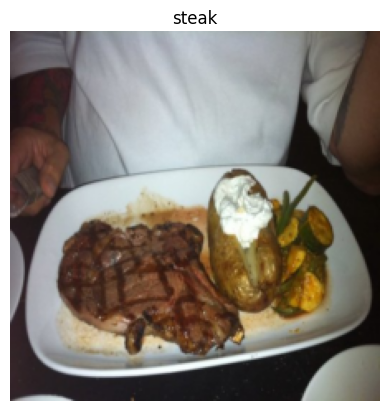

In [24]:
# 1. View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f"{bcolors.OKCYAN} [INFO] Image shape: {image.shape}{bcolors.ENDC}")

# 2. Pass the image through the conv2d layer
img_out_of_conv = conv2d(image.unsqueeze(0))
print(f"{bcolors.OKGREEN} [INFO] Conv2d output shape: {img_out_of_conv.shape}{bcolors.ENDC}")

# 3. Pass the conv2d output through the flatten layer
img_out_of_flatten = flatten(img_out_of_conv)
print(f"{bcolors.OKCYAN} [INFO] Flatten output shape: {img_out_of_flatten.shape}{bcolors.ENDC}")

Woohoo! It looks like our image_out_of_conv_flattened shape is very close to our desired output shape:

* Desired output (flattened 2D patches): (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$
* Current shape: (1, 768, 196)


In [25]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = img_out_of_flatten.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


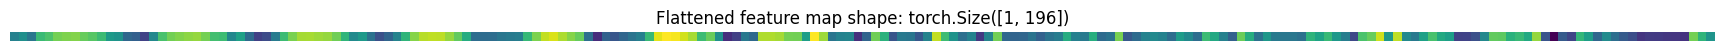

In [26]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [27]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.3276,  0.3775,  0.2897,  0.5393,  0.5746,  0.6389,  0.6496,  0.6569,
           0.6176,  0.5929,  0.5442,  0.4202,  0.3916,  0.2346,  0.2107,  0.1132,
           0.3507,  0.5679,  0.6341,  0.6554,  0.6724,  0.6817,  0.6376,  0.5585,
           0.5461,  0.3471,  0.4453,  0.2487,  0.1111,  0.1449,  0.3072,  0.5430,
           0.6439,  0.7027,  0.7077,  0.6912,  0.6819,  0.6305,  0.5177,  0.3630,
           0.4152,  0.2730,  0.1593,  0.2219,  0.3336,  0.5182,  0.6631,  0.7263,
           0.7382,  0.7348,  0.6830,  0.6092,  0.4851,  0.2546,  0.2519,  0.2561,
           0.2870,  0.3045,  0.3146,  0.5292,  0.6471,  0.7420,  0.7713,  0.7124,
           0.6611,  0.6161,  0.2613,  0.0503,  0.2156,  0.1734,  0.2303,  0.2784,
           0.3191,  0.5325,  0.7868,  0.8186,  0.8101,  0.7604,  0.7079,  0.5447,
           0.6208,  0.3826,  0.0557,  0.1077,  0.2941,  0.2391,  0.7175,  0.7152,
           0.7037,  0.6368,  0.6345,  0.4333,  0.8220,  0.6930,  0.2833,  0.3321,
           0.342

## 4.5 Turning the ViT patch embedding layer into a PyTorch module


In [28]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """
    Turns a 2D input image into a 1D sequence learnable patch embeddings vector.
    
    Args:
        in_channels (int): Number of color channels for the input iamges. Default is 3.
        patch_size (int): The patch size to turn the image into. Default is 16.
        embedding_dim (int): The number of feature embedding dimensions. Default is 768.
    """
    # 2. Initialze class with appropriate parameters
    def __init__(self,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super(PatchEmbedding, self).__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        
        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are te correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, "Image resolution must be divisible by the patch size"
        
        # perform the forward pass
        return self.flatten(self.patcher(x)).permute(0, 2, 1)
        

In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [30]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## 4.6 Creating the class token embeddingg

In [31]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.4136,  0.1046, -0.1341,  ...,  0.2863, -0.1301,  0.1186],
         [-0.4317,  0.1226, -0.1467,  ...,  0.3084, -0.1558,  0.1433],
         [-0.5552,  0.1298, -0.1750,  ...,  0.3376, -0.1633,  0.1553],
         ...,
         [-0.8194,  0.3092, -0.2428,  ...,  0.5624, -0.0786,  0.0780],
         [-0.5352,  0.1031, -0.1549,  ...,  0.4265, -0.2858,  0.2414],
         [-0.4103,  0.0678, -0.1135,  ...,  0.3068, -0.2187,  0.1868]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [32]:
# Let's create a learnable embedding for the class token.

# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

# Create a class token embedding as a learnable parameter that shares the same size as the patch embedding
class_token = nn.Parameter(
    torch.randn(batch_size, 1, embedding_dim),
    requires_grad=True
)

# Show the first 10 values of the class token
print(class_token[:, :, :10])

# Print the shape of the class token
print(f"{bcolors.OKCYAN} [INFO] Class token shape{class_token.shape}{bcolors.ENDC}")

tensor([[[-2.4663,  0.4867,  0.8128,  0.3298, -1.6121, -0.5759, -0.2281,
           0.2943,  0.1197,  1.5855]]], grad_fn=<SliceBackward0>)
 [INFO] Class token shapetorch.Size([1, 1, 768])


In [33]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-2.4663,  0.4867,  0.8128,  ...,  0.9203,  0.2370,  1.4758],
         [-0.4136,  0.1046, -0.1341,  ...,  0.2863, -0.1301,  0.1186],
         [-0.4317,  0.1226, -0.1467,  ...,  0.3084, -0.1558,  0.1433],
         ...,
         [-0.8194,  0.3092, -0.2428,  ...,  0.5624, -0.0786,  0.0780],
         [-0.5352,  0.1031, -0.1549,  ...,  0.4265, -0.2858,  0.2414],
         [-0.4103,  0.0678, -0.1135,  ...,  0.3068, -0.2187,  0.1868]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## 4.7 Creating the position embedding

In [34]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[-2.4663,  0.4867,  0.8128,  ...,  0.9203,  0.2370,  1.4758],
          [-0.4136,  0.1046, -0.1341,  ...,  0.2863, -0.1301,  0.1186],
          [-0.4317,  0.1226, -0.1467,  ...,  0.3084, -0.1558,  0.1433],
          ...,
          [-0.8194,  0.3092, -0.2428,  ...,  0.5624, -0.0786,  0.0780],
          [-0.5352,  0.1031, -0.1549,  ...,  0.4265, -0.2858,  0.2414],
          [-0.4103,  0.0678, -0.1135,  ...,  0.3068, -0.2187,  0.1868]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# Calculate N (Number of patches)
number_of_patches = int((height*width)/patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create a learnable 1D position embedding
position_embedding = nn.Parameter(
    torch.randn(1,
                number_of_patches+1,
                embedding_dimension),
    requires_grad=True
)

# Show the first 10 values of the position embedding
print(position_embedding[:, :, :10])
print(f"{bcolors.OKCYAN} [INFO] Position embedding shape: {position_embedding.shape}{bcolors.ENDC}")

tensor([[[-0.7411,  0.8154, -0.3632,  ...,  0.0941, -1.0380,  0.8571],
         [-0.6329,  0.6017,  0.7737,  ...,  1.1979,  1.0343, -0.8025],
         [ 0.4181, -0.8031,  0.6838,  ...,  0.0829, -0.4846,  0.5666],
         ...,
         [-0.2004, -2.7290, -0.4892,  ..., -0.5205, -1.0049, -0.2517],
         [ 0.4338,  0.2027,  0.7711,  ..., -0.0592,  1.3449,  0.8999],
         [-1.7389,  0.7569, -1.0380,  ..., -1.5240, -0.5123,  0.1694]]],
       grad_fn=<SliceBackward0>)
 [INFO] Position embedding shape: torch.Size([1, 197, 768])


In [36]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-3.2074,  1.3021,  0.4496,  ...,  2.0919, -0.4471, -0.3826],
         [-1.0466,  0.7063,  0.6396,  ..., -0.1442, -1.3062,  0.6226],
         [-0.0135, -0.6806,  0.5370,  ...,  0.2029,  1.0521, -1.0242],
         ...,
         [-1.0198, -2.4198, -0.7321,  ..., -1.1436,  0.0879,  1.3367],
         [-0.1014,  0.3058,  0.6162,  ...,  0.1766, -0.9713,  0.2076],
         [-2.1492,  0.8247, -1.1515,  ..., -1.2915, -0.3736,  0.6441]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## 4.8 Putting it all together: from image to embedding

In [37]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the iamge dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.randn(batch_size, 1, embedding_dim),
    requires_grad=True
)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# 5. Equation 2: Multi-Head `<Self>` Attention (MSA)


# 5.1 Replicating Equation 2 with PyTorch layers

In [38]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttention(nn.Module):
    """
    Create a multi-head self-attention block.
    """
    # 2. Initialize the class with hyperparameters
    def __init__(self,
                 embedding_dim: int = 768,
                 num_head : int = 12,
                 attn_dropout: float = 0.0,
                 ):
        super(MultiheadSelfAttention, self).__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) Layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_head,
            dropout=attn_dropout,
            batch_first=True,
        )    
        
    # 5. Define the forward method
    
    def forward(self, x):
        x = self.layer_norm(x)
        
        # 6. Perform the multi-head attention
        attn_output, _ = self.multihead_attn(
            query=x,
            key=x,
            value=x,
            need_weights=False
        )
        return attn_output

In [39]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttention(
    embedding_dim=768,
    num_head=12,
)

# pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"{bcolors.OKGREEN} [INFO] Input shape of MSA blcok: {patch_and_position_embedding.shape}")
print(f"{bcolors.OKCYAN} [INFO] Output shape of MSA block: {patched_image_through_msa_block.shape}{bcolors.ENDC}")

 [INFO] Input shape of MSA blcok: torch.Size([1, 197, 768])
 [INFO] Output shape of MSA block: torch.Size([1, 197, 768])


# 6. Equation 3: Multilayer Perceptron (MLP)

In [40]:
# Let's replicate the MLP Block
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """
    Creates alayer Normalized multilayer perceptron block.
    """
    # 2. Initialize the class with hyperparameters
    def __init__(
        self,
        embedding_dim: int = 769,
        mlp_size: int = 3072,
        dropout: float = 0.1
    ):
        super(MLPBlock, self).__init__()
        # 3. Create the layer norm
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(mlp_size, embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    # 5. Define the forward method
    def forward(self, x):
        return self.mlp(self.layer_norm(x))

In [41]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


# 7. Create the Transformer Encoder

We now have all the building block to create a single encoder block
by stack everything we have created.

## 7.1 Creating a Transformer Encoder by combining our custom made layers


In [42]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """
    Creates a Transformer Encoder Block.
    """
    # 2. Initialize the class with hyperparameters
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 attn_dropout: float = 0.1,
                 dropout: float = 0.1):
        super().__init__()
        
        # 3. Create MSA block
        self.msa_block = MultiheadSelfAttention(
            embedding_dim=embedding_dim,
            num_head=num_heads,
            attn_dropout=attn_dropout
        )
        
        # 4. Create MLP block
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=dropout
        ) 
        
    # 5. Define the forward method
    def forward(self, x):
        # 6. Create a residual connection for the MSA block
        x = x + self.msa_block(x)
        
        # 7. Create a residual connection for the MLP block
        x = x + self.mlp_block(x)
        
        return x
        

In [43]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttention (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

PyTorch dues to rise in popularity and effectiveness of Transformers have in-built layer called `nn.TransformerEncoderLayer()`

In [44]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [45]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

# 8. Putting it all together to craete ViT

In [46]:
# 1. Create a ViT model class that subclasses nn.Module
class ViT(nn.Module):
    """Create a Vision Transformer architecture with ViT-Base hyperparmeters by default."""
    # 2. Initialize the class with hyperparameters 
    def __init__(self,
                 img_size: int = 224,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 num_transformer_layers: int = 12,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072,
                 num_heads: int = 12,
                 attn_dropout: float = 0.0,
                 mlp_dropout: float = 0.1,
                 embedding_dropout: float = 0.1,
                 num_classes: int = 1000
                 ):
        super(ViT, self).__init__()
        
        # 3. Make sure the image size is divisible by the patch size
        assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size"
        
        # 4. Calculate number of patches (height * width / patch_size^2)
        self.num_patches = (img_size * img_size) // (patch_size * patch_size)
        
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim),
            requires_grad=True
        )
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches + 1, embedding_dim),
            requires_grad=True
        )
        
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder Blocks (we can stack TransformerEncoderBlocks using nn.Sequential)
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                attn_dropout=attn_dropout,
                dropout=mlp_dropout
            ) for _ in range(num_transformer_layers)
            ])
        
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(embedding_dim, num_classes)
        )
        
    # 11. Define the forward method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size 
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        
        # 14. Create patch embedding
        x = self.patch_embedding(x)
        
        # 15. Prepend the class token to the sequence of patch embeddings
        x = torch.cat((class_token, x), dim=1)
        
        # 16. Add position embedding
        x += self.position_embedding
        
        # 17. Pass through embedding dropout
        x = self.embedding_dropout(x)
        
        # 18. Pass through the transformer encoder blocks
        x = self.transformer_encoder(x)
        
        # 19. Take just the class token (index at 0)
        x = self.classifier(x[:, 0]) 
        
        return x

In [47]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [48]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

## 8.1 Getting a visual summary of our ViT model

In [49]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

# Setting up training code for ou ViT model

## 9.1 Creating an optimizer, loss function and training

In [50]:
from going_modular import engine

# Setup the optimizer to optimize our ViT model parameters with an Adam optimizer
optimizer = torch.optim.Adam(vit.parameters(), 
                             lr=3e-4,
                             betas=(0.9,0.999),
                             weight_decay=0.3)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4384 | train_acc: 0.4062 | test_loss: 1.6148 | test_acc: 0.2803
Epoch: 2 | train_loss: 1.4859 | train_acc: 0.3320 | test_loss: 1.3014 | test_acc: 0.2973
Epoch: 3 | train_loss: 1.2260 | train_acc: 0.2539 | test_loss: 1.2920 | test_acc: 0.2377
Epoch: 4 | train_loss: 1.4336 | train_acc: 0.2812 | test_loss: 1.1373 | test_acc: 0.3826
Epoch: 5 | train_loss: 1.3347 | train_acc: 0.2852 | test_loss: 1.5227 | test_acc: 0.4025
Epoch: 6 | train_loss: 1.4418 | train_acc: 0.4258 | test_loss: 1.7939 | test_acc: 0.2576
Epoch: 7 | train_loss: 1.2897 | train_acc: 0.4414 | test_loss: 1.3665 | test_acc: 0.4025
Epoch: 8 | train_loss: 1.4057 | train_acc: 0.3945 | test_loss: 1.2002 | test_acc: 0.3598
Epoch: 9 | train_loss: 1.2330 | train_acc: 0.2812 | test_loss: 1.1331 | test_acc: 0.3598
Epoch: 10 | train_loss: 1.2610 | train_acc: 0.2930 | test_loss: 1.1108 | test_acc: 0.4025


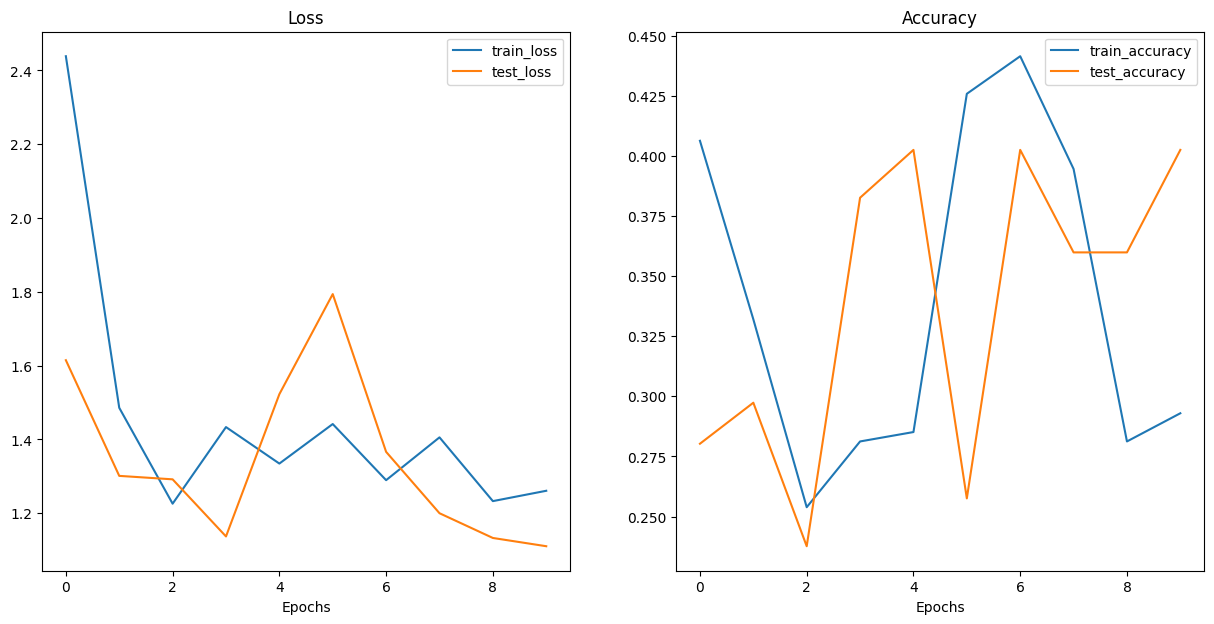

In [51]:
# Since our model is randomly intialize and we have small dataset, we will not get good results
# Plot the loss curves

from utils import  plot_loss_curves

plot_loss_curves(results)

# 10. Using a pretrained ViT from `torchvision.models()` on the same dataset

# 10.1 Gettingg a pretrained ViT model and creating a feature extractor

In [52]:
import torch
import torchvision


In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{bcolors.OKCYAN} [INFO] Using {device} device{bcolors.ENDC}")

 [INFO] Using cpu device


In [56]:
from torchvision.models import ViT_B_16_Weights, vit_b_16

# 1. Get pretrained weights for ViT-B/16
pretrained_weights = ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = vit_b_16(weights=pretrained_weights)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head to output 3 classes
set_seeds()

pretrained_vit.heads = nn.Linear(in_features=768, out_features=3)

pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [57]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## 10.3 Preparing data for the pretrained ViT model

In [ ]:
from utils import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

In [58]:
# Since i have already downloaded the data, i will just set the path
from pathlib import Path
image_path = Path("data/pizza_steak_sushi/")

# Setup directory paths to train and test data
train_dir = image_path / "train"
test_dir = image_path / "test"

image_path, train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi'),
 WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [60]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [62]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloader(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     train_transform=pretrained_vit_transforms,
                                                                                                     test_transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) 


## 10.4 Train feature extractor ViT model

In [63]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5210 | test_acc: 0.8968
Epoch: 2 | train_loss: 0.3467 | train_acc: 0.9414 | test_loss: 0.2671 | test_acc: 0.9583
Epoch: 3 | train_loss: 0.2308 | train_acc: 0.9492 | test_loss: 0.2084 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.1544 | train_acc: 0.9648 | test_loss: 0.2274 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.1329 | train_acc: 0.9648 | test_loss: 0.1601 | test_acc: 0.9583
Epoch: 6 | train_loss: 0.1136 | train_acc: 0.9766 | test_loss: 0.1526 | test_acc: 0.9583
Epoch: 7 | train_loss: 0.1466 | train_acc: 0.9766 | test_loss: 0.1624 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.0837 | train_acc: 0.9805 | test_loss: 0.1650 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.0837 | train_acc: 0.9805 | test_loss: 0.1538 | test_acc: 0.9375
Epoch: 10 | train_loss: 0.0687 | train_acc: 0.9883 | test_loss: 0.2205 | test_acc: 0.9176


In [64]:
# See the results are great now but still could be better with more data

## 10.5 Plot feature extractor ViT model loss curves

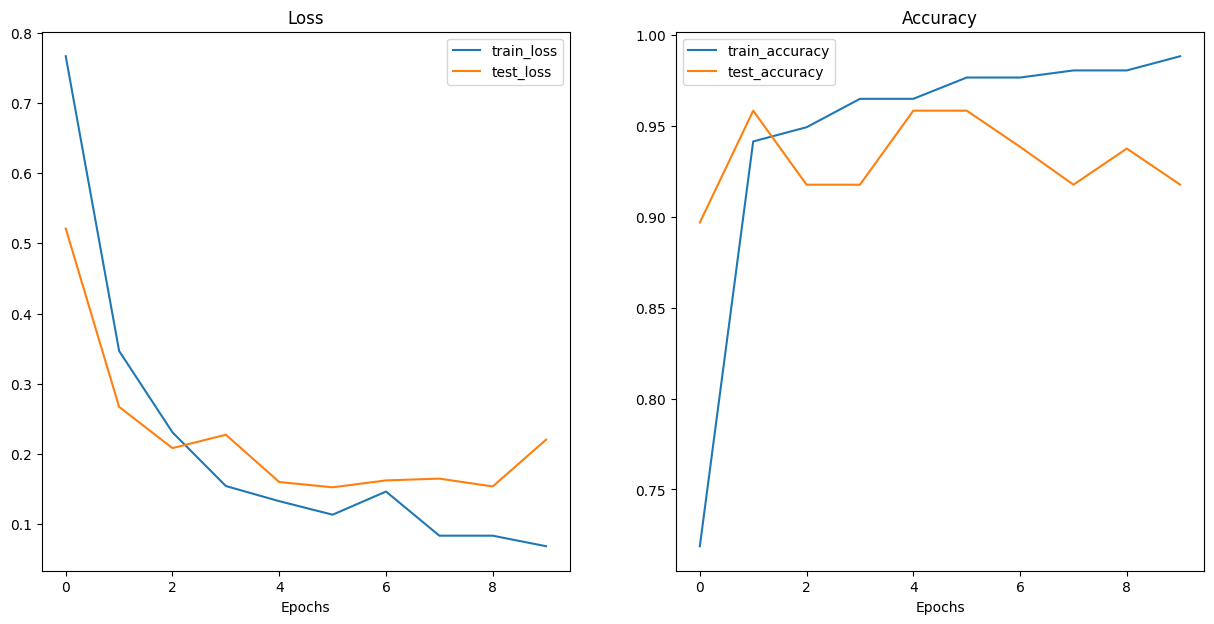

In [65]:
# Plot the loss curves
from utils import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [66]:
# Save the model
from going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [67]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


# 11. Make predictions on a custom image

data\pizza_steak_sushi\04-pizza-dad.jpeg already exists, skipping download.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0940216..2.4847243].


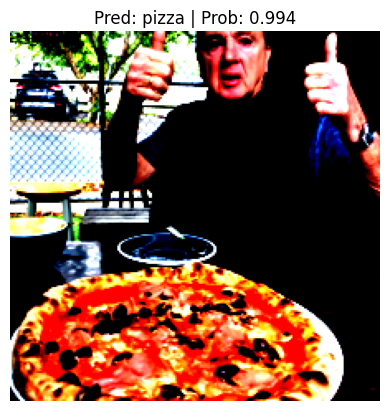

In [70]:
import requests

# Import function to make predictions on images and plot them
from utils import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    transform=pretrained_vit_transforms,
                    class_names=class_names)